In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


SEED = 314159
TRAIN_TEST_SPLIT = 0.80

data_path = r"C:\Users\nikol_ri8fhbe\Documents\ml"

In [23]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                           n_redundant=5, random_state=42)

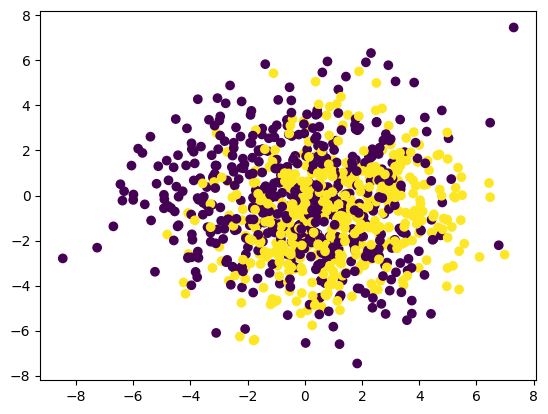

In [24]:
plt.scatter(X[:, 2], X[:, 3], c=y)

# Ансамбли: бустинги


Бустинг строится последовательно: каждое следующее дерево в нем обучается на основе результатов предыдущего, пытаясь уменьшить его ошибку. Как следствие, композиция будет иметь меньшее смещение, чем исходные базовые модели. Поэтому логично в качестве базовых моделей использовать те, которые изначально обладают небольшим разбросом и высоким смещением. Вопрос: какие это будут модели?
Еще одно соображение для выбора сильно смещенных моделей в том, что они банально быстрее учатся. Так как невозможно распараллелить обучение базовых моделей, то скорость их настройки становится серьезным вопросом. 

Что интересно, бустинги не очень хорошо работают с однородными данными - поэтому их нечасто применяют для текстов.

Расссмотрим квадратичную функцию потерь и композицию следующего вида: $ a = b_1 +  b_2 + ... + b_N $
Обучим только одно дерево $ a = b_1 $. Найдем примеры, для которых оно ошибается в  предсказании. Обучим для них еще одно дерево - $ b_2 $, которое будет предсказывать ошибку первого. Будем повторять это, пока не наберем K деревьев. Примерно так на верхнем уровне обучается бустинг. 


In [25]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

def eval_classifier(clf):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=43)
    n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(n_scores), np.std(n_scores)

In [26]:
results_accuracy = pd.DataFrame(0.0,
                                columns=["W/o ensembling", 'Bagging', "Bagging_with_mf", 'AdaBoost'],
                                index=['deep DTC', '1-level DTC', 'LR', 'SVC'])

In [27]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier())

results_accuracy.loc['deep DTC', 'W/o ensembling'] = acc_mean
print(f"{acc_mean:.2f}, +- {acc_std:.2f}")

0.79, +- 0.04


In [28]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier(max_depth=1))

results_accuracy.loc['1-level DTC', 'W/o ensembling'] = acc_mean
print(f"{acc_mean:.2f} +- {acc_std:.2f}")

0.68 +- 0.04


In [29]:
from sklearn.ensemble import BaggingClassifier

In [30]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['deep DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.86, 0.04


In [31]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['1-level DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.69, 0.04


In [32]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['deep DTC', 'Bagging_with_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.87, 0.03


In [33]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['1-level DTC', 'Bagging_with_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.70, 0.03


In [34]:
results_accuracy

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.792333,0.861333,0.866000,0.0
1-level DTC,0.683333,0.685667,0.696333,0.0
LR,0.000000,0.000000,0.000000,0.0
SVC,0.000000,0.000000,0.000000,0.0


**Задание**: Дополните таблицу: обучите также логистическую регрессию с беггингом и без него.

In [35]:
from sklearn.linear_model import LogisticRegression

# Логистическая регрессия без ансамблирования
acc_mean, acc_std = eval_classifier(LogisticRegression())
results_accuracy.loc['LR', 'W/o ensembling'] = acc_mean
print(f"Точность: {acc_mean:.2f}, ± {acc_std:.2f}")

# Логистическая регрессия с бэггингом (все признаки)
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(), n_estimators=10,
    max_samples=1.0, max_features=1.0,
    bootstrap=True, bootstrap_features=False))
results_accuracy.loc['LR', 'Bagging'] = acc_mean
print(f"Точность: {acc_mean:.2f}, ± {acc_std:.2f}")

# Логистическая регрессия с бэггингом (80% признаков)
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(), n_estimators=10,
    max_samples=1.0, max_features=0.8,
    bootstrap=True, bootstrap_features=False))
results_accuracy.loc['LR', 'Bagging_with_mf'] = acc_mean
print(f"Точность: {acc_mean:.2f}, ± {acc_std:.2f}")

results_accuracy

Точность: 0.81, ± 0.03
Точность: 0.81, ± 0.04
Точность: 0.81, ± 0.03


,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.792333,0.861333,0.866000,0.0
1-level DTC,0.683333,0.685667,0.696333,0.0
LR,0.811333,0.812667,0.813667,0.0
SVC,0.000000,0.000000,0.000000,0.0


## AdaBoost

AdaBoost обучает каждый следующий классификатор на объектах, на которых ошибаются предыдущие (объекты с ошибками получают больший вес, без ошибок — меньший).

In [36]:
from sklearn.ensemble import AdaBoostClassifier

In [37]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['deep DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.79, 0.04


In [38]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['1-level DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.81, 0.04


In [39]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.792,0.861,0.866,0.789
1-level DTC,0.683,0.686,0.696,0.813
LR,0.811,0.813,0.814,0.000
SVC,0.000,0.000,0.000,0.000


**Задание:** выясните, дадут ли улучшение бэггинг и бустинг над линейной регрессией. Объясните, почему так.

Бэггинг и бустинг не дают значимого улучшения для логистической регрессии, так как это линейная модель, и ансамблирование слабо влияет на её работу. Лучший результат (0.813) лишь незначительно выше базового (0.811).

Вопрос: Почему AdaBoost хуже работает на глубоких деревьях?

AdaBoost хуже работает на глубоких деревьях, потому что они склонны к переобучению, а бустинг усиливает эту проблему.

# Градиентный бустинг

Рассмотрим композицию $a = \sum_{i} {\gamma_i b_i}$. Для начала выбирается какой-нибудь простой $\gamma_0, b_0$ (например, 0 и среднее). Формально каждая N-ая модель, начиная со второй, пытается приблизиить антиградиент функционала ошибки, взятый в точках ${z_i=a_{N-1}(x_i)}$:
$$s_i = -\dfrac{\partial L(y, z)}{\partial z}|_{z=a_{N-1}}$$
Подбор алгоритма при этом производится, приближая эту ошибку c точки зрения квадратичной функции потерь.
$$ b_i = arg \min_{b \in \mathcal{B}} {\sum (b_i(x) - s_i)^2} $$

Градиентный бустинг - довольно мощная метамодель, с огромным количеством параметров и хитростей. Мы сегодня остановимся только на основных. Для начала рассмотрим самый стандартный бустинг с использованием деревьев решений (CART). Параметры базовых моделей такие же, как и раньше, но настройка амого бустинга довольно сложна!

Важный вопрос при обучении модели - какую функцию ошибок выбрать? Какая задача возникает при обработке датасета с вином?

Для того, чтобы оценивать модель, полезны различные метрики - численные характеристики ее качества. При этом бустинги настолько галантны, что предоставляют нам возможность оценивать метрики прямо при обучении. Для этого необходимо задать тип метрики в конструкторе и eval_set при запуске fit().

На практике обычно используется один из трех вариантов бустинга - Xgboost, LightGBM или CatBoost.

### [XGBoost](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf).
Плюсы:
- Позволяет легко паралелить вычисления (например на спарке)
- Легко использовать с sklearn и numpy (но с потерей производительности)
- Поддерживается обработка разреженных данных
- Предсортированные блоки, кэши, шардирование

Минусы:
- Нет поддержки GPU

[документация](https://xgboost.readthedocs.io/en/latest/)

  
### [LightGBM](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
Плюсы:
- Поддержка GPU
- Метод Фишера для работы с категориальными признаками
- Уменьшение размера обучающей выборки (GOSS)
- Объединение разреженных признаков (EFB)

Минусы:
- Итерфейс не совместим с sklearn/numpy

[документация](https://lightgbm.readthedocs.io/en/latest/Python-API.html)

### [CatBoost](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
Плюсы:
- Поддержка GPU
- Легко использовать с sklearn и numpy
- Более продвинутая работа с категориальными фичами
- Наши слоны
  
Минусы:
- Бывает работает хуже (возможно слабее эвристики), но с категориальными фичами — хорошо

[документация](https://catboost.ai/docs/concepts/python-quickstart.html)


In [40]:
from catboost import CatBoostClassifier

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        depth=1,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True, 
        task_type='CPU'))

сat_boost = acc_mean

results_accuracy.loc['1-level DTC', 'CatBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.76, 0.04


In [41]:
from catboost import CatBoostClassifier

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True, 
        task_type='CPU'))

сat_boost = acc_mean

results_accuracy.loc['deep DTC', 'CatBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.86, 0.03


In [42]:
from xgboost import XGBClassifier
acc_mean, acc_std = eval_classifier(XGBClassifier(objective='binary:logistic', random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

results_accuracy.loc['deep DTC', 'XGBoost'] = acc_mean

0.92, 0.03


In [43]:
acc_mean, acc_std = eval_classifier(XGBClassifier(objective='binary:logistic', max_depth=1, random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

results_accuracy.loc['1-level DTC', 'XGBoost'] = acc_mean

0.84, 0.03


In [44]:
results_to_show = results_accuracy.copy()
results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost,CatBoost,XGBoost
deep DTC,0.792,0.861,0.866,0.789,0.862,0.920
1-level DTC,0.683,0.686,0.696,0.813,0.759,0.841
LR,0.811,0.813,0.814,0.000,nan,nan
SVC,0.000,0.000,0.000,0.000,nan,nan


In [45]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label=y)

param = {'num_leaves': 31, 
         'objective': 'multiclass', 
         'num_class': 2, 
         'metric': ['multi_logloss']}

num_round = 10
boost = lgb.train(param, train_data, num_boost_round=10)

lg_boost = (boost.predict(X).argmax(axis=-1) == y).mean()

results_accuracy.loc['deep DTC', 'LightGBM'] = lg_boost
print(f"{lg_boost:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 20
[LightGBM] [Info] Start training from score -0.689155
[LightGBM] [Info] Start training from score -0.697155
0.95


In [46]:
results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost,CatBoost,XGBoost,LightGBM
deep DTC,0.792,0.861,0.866,0.789,0.862,0.920,0.947
1-level DTC,0.683,0.686,0.696,0.813,0.759,0.841,nan
LR,0.811,0.813,0.814,0.000,nan,nan,nan
SVC,0.000,0.000,0.000,0.000,nan,nan,nan


## Пример
Рассмотрим реальный датасет, и на его примере попробуем поработать с бустингом.

In [47]:
ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)


NameError: name 'datasets' is not defined

In [ ]:
model = XGBRegressor(n_estimators=100, learning_rate=1, seed=SEED)
fit_params = {"eval_set":[(X_train, y_train),(X_test, y_test)], "verbose": False}
# Add verbose=False to avoid printing out updates with each cycle
model.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=False)

In [ ]:
results = model.evals_result()

In [ ]:
error_function = "rmse"
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][error_function], label="Training loss")
plt.plot(results["validation_1"][error_function], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

Как мы видим, хотя лосс при обучении падал и падал, на валидации метрики перестали улучшаться довольно рано. Это довольно плохой знак. Однако говорит ли это о катастрофической ситуации? Проверим переобучение с помощью кросс-валидации.

In [ ]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                            return_train_score=True)
print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())


Кажется, у нас действительно серьезные проблемы. Попробуем уменьшить скорость обучения.


In [ ]:
# train and eval model with smaller lr
model = XGBRegressor(n_estimators=100, learning_rate=0.01, seed=SEED)
fit_params = {"eval_set":[(X_train, y_train),(X_test, y_test)], "verbose": False}
# Add verbose=False to avoid printing out updates with each cycle
model.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=False)

In [ ]:
# plot results
results = model.evals_result()
error_function = "rmse"
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][error_function], label="Training loss")
plt.plot(results["validation_1"][error_function], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

Помогло ли это? Попробуем получить результаты лучше, поиграв с параметрами.

In [ ]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                            return_train_score=True)
print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())


In [ ]:
model = XGBRegressor(
   n_estimators=200,
    learning_rate=0.1, 
    max_depth=3,        
    subsample=0.8,      
    colsample_bytree=0.8,  
    seed=SEED
)

Так как параметров довольно много, может быть разумно автоматизировать их поиск. Для этого воспользуемся поиском по решетке.

In [48]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
SEED = 42

fit_params = {
    "eval_set": [(X_train, y_train), (X_test, y_test)],
    "verbose": False
}

xgboost_params = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200]
}

xgboost_best_grid = GridSearchCV(
    XGBRegressor(seed=SEED),
    xgboost_params,
    cv=7,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    return_train_score=True
).fit(X_train, y_train, **fit_params)

print("Лучшие параметры:", xgboost_best_grid.best_params_)

Лучшие параметры: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}


Давайте проверим, какую точность мы получим с лучшими параметрами.

**Задание:** Проведите обучение и с LightGBM/CatBoost. Какие лучшие точности у вас получилось получить?

In [49]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'num_leaves': [15, 31],
    'n_estimators': [100, 200]
}

lgbm_grid = GridSearchCV(LGBMRegressor(random_state=SEED),
                        lgbm_params,
                        cv=5,
                        scoring='neg_root_mean_squared_error')
lgbm_grid.fit(X_train, y_train)
print("LightGBM лучшие параметры:", lgbm_grid.best_params_)
print("LightGBM лучший RMSE:", -lgbm_grid.best_score_)

catboost_params = {
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6],
    'iterations': [100, 200]
}

cb_grid = GridSearchCV(CatBoostRegressor(random_state=SEED, verbose=0),
                     catboost_params,
                     cv=5,
                     scoring='neg_root_mean_squared_error')
cb_grid.fit(X_train, y_train)
print("\nCatBoost лучшие параметры:", cb_grid.best_params_)
print("CatBoost лучший RMSE:", -cb_grid.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 176, number of used features: 10
[LightGBM] [Info] Start training from score 146.454545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 177, number of used features: 10
[LightGBM] [Info] Start training from score 155.785311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 176, number of used features: 10
[LightGBM] [Info] Start training from score 146.454545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 177, number of used features: 10
[LightGBM] [Info] Start training from score 151.745763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 177, number of used features: 10
[LightGBM] [Info] Start training from score 151.745763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

**Задание:** Постройте графики предсказаний для первых двух PCA фичей для бустингов разной глубины/разного числа деревьев.

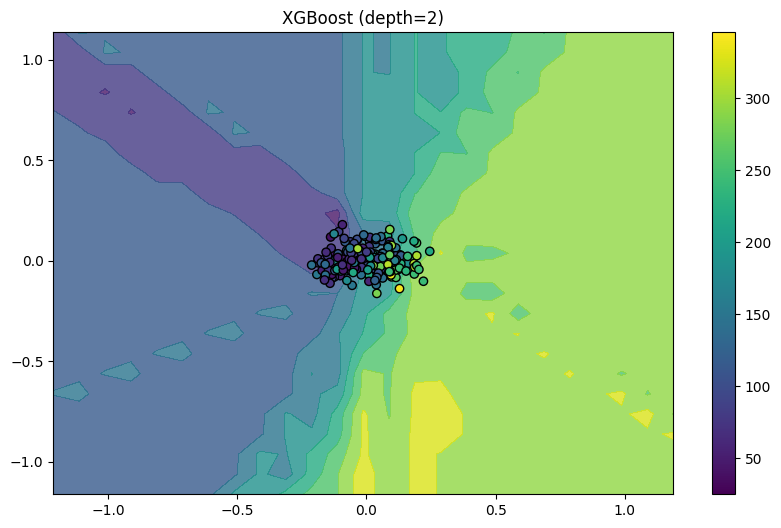

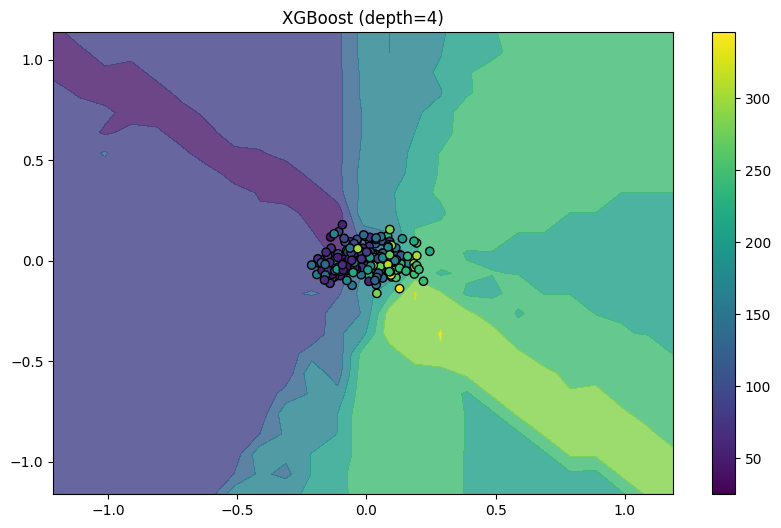

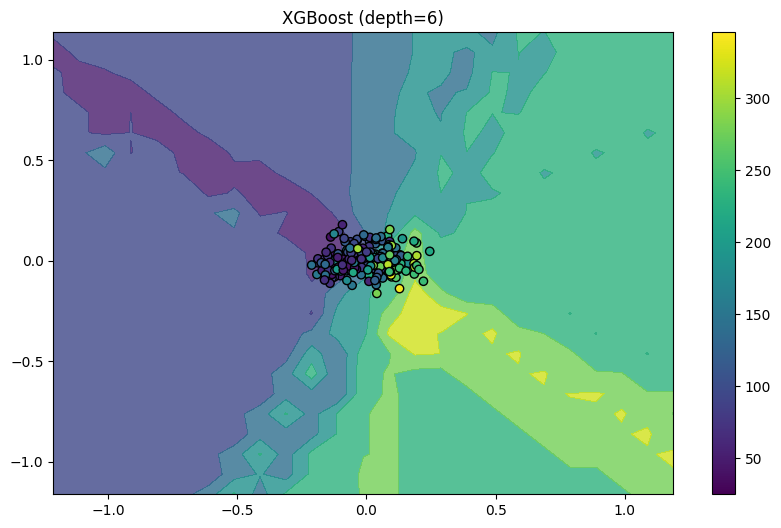

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

def plot_predictions(model, title):
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolor='k')
    plt.title(title)
    plt.colorbar()
    plt.show()
    
for depth in [2, 4, 6]:
    model = XGBRegressor(max_depth=depth, n_estimators=50, random_state=SEED)
    model.fit(X_train, y_train)
    plot_predictions(model, f'XGBoost (depth={depth})')

**Задание**: Постройте график зависимости точности от глубины

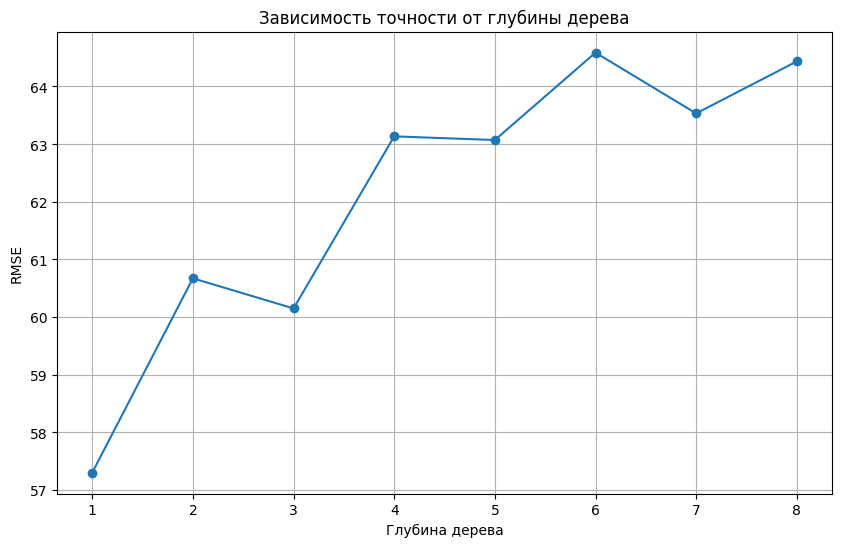

In [52]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

depths = range(1, 9)
rmse_scores = []

for depth in depths:
    model = XGBRegressor(max_depth=depth, n_estimators=100, random_state=SEED)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)  
    rmse_scores.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(depths, rmse_scores, marker='o')
plt.xlabel('Глубина дерева')
plt.ylabel('RMSE')
plt.title('Зависимость точности от глубины дерева')
plt.grid()
plt.show()